## 1. Two-dimensional data

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from sklearn.datasets import make_moons

#### MMD calculation

In [8]:
def calculate_mmd(X1, X2, kernel='rbf', bandwidth=1.0):
    n1, n2 = X1.shape[0], X2.shape[0]
    if kernel == 'rbf':
        # Squared Exponential (RBF) kernel
        Kxx = np.mean(np.exp(-0.5 * np.square(np.linalg.norm(X1[:, np.newaxis] - X1, axis=2) / bandwidth**2)))
        Kxy = np.mean(np.exp(-0.5 * np.linalg.norm(X1[:, np.newaxis] - X2, axis=2) / bandwidth**2))
        Kyy = np.mean(np.exp(-0.5 * np.square(np.linalg.norm(X2[:, np.newaxis] - X2, axis=2) / bandwidth**2)))
    elif kernel == 'imq':
        # Inverse Multi-Quadratic kernel
        Kxx = np.mean(1 / np.sqrt(1 + np.square(np.linalg.norm(X1[:, np.newaxis] - X1, axis=2) / bandwidth**2)))
        Kxy = np.mean(1 / np.sqrt(1 + np.square(np.linalg.norm(X1[:, np.newaxis] - X2, axis=2) / bandwidth**2)))
        Kyy = np.mean(1 / np.sqrt(1 + np.square(np.linalg.norm(X2[:, np.newaxis] - X2, axis=2) / bandwidth**2)))
    else:
        raise ValueError("Invalid kernel type. Choose 'rbf' or 'imq'.")

    mmd = Kxx - 2 * Kxy + Kyy

    return mmd

#### Histogram

In [9]:
#1. a two-dimensional histogram
def histogram_density_estimation(data, bins, num_samples):
    range_x = [data[:, 0].min(), data[:, 0].max()]
    range_y = [data[:, 1].min(), data[:, 1].max()]
    x, y = data[:, 0], data[:, 1]
    #bins is a hyperparameter
    #create evenly spaced bins
    x_bins = np.linspace(range_x[0], range_x[1], bins)
    y_bins = np.linspace(range_y[0], range_y[1], bins)
    #initialise the histogram density estimation
    density = np.zeros((bins, bins))
    #compute densities
    for i in range(bins-1):
        for j in range(bins-1):
            x_mask = (x >= x_bins[i]) & (x <= x_bins[i + 1])
            y_mask = (y >= y_bins[j]) & (y <= y_bins[j + 1])
            density[i, j] = np.sum(x_mask & y_mask)
    #Normalize the density
    density /= np.sum(density)
    #flatten the density matrix
    density_flat = density.ravel()
    #generate new data points using a uniform distribution
    new_samples = []
    for _ in range(num_samples):
        idx = np.random.choice(len(density_flat), p=density_flat)
        i, j = np.unravel_index(idx, density.shape)
        new_x = np.random.uniform(x_bins[i], x_bins[i + 1])
        new_y = np.random.uniform(y_bins[j], y_bins[j + 1])
        new_samples.append([new_x, new_y])
    return density,np.array(new_samples)

#### Single Gaussian

In [10]:
#2. a single Gaussian
def generate_single_gaussian_data(data, num_samples):
    np.random.seed(0)
    mean = np.mean(data, axis=0)
    covariance_matrix = np.cov(data, rowvar=False)
    gaussian_data = multivariate_normal(mean=mean, cov=covariance_matrix)
    samples = gaussian_data.rvs(size=num_samples) #generates random samples (variates) from the Gaussian distribution 
    return gaussian_data,samples

#### Gaussian Mixture Model

In [11]:
#3. a Gaussian mixture model (GMM)
def gmm_density_estimation_and_sampling(X, num_components, num_samples):
    np.random.seed(0)
    n_samples, n_features = X.shape
    means = X[np.random.choice(n_samples, num_components, replace=False)]
    covariances = [np.eye(n_features) for _ in range(num_components)]
    mixing_coefficients = np.ones(num_components) / num_components

    # Expectation-Maximization (EM) algorithm
    n_iterations = 100
    for _ in range(n_iterations):
        responsibilities = []
        for i in range(num_components):
            component_likelihood = multivariate_normal(means[i], covariances[i]).pdf(X)
            responsibilities.append(mixing_coefficients[i] * component_likelihood)
        responsibilities = np.array(responsibilities)
        responsibilities /= np.sum(responsibilities, axis=0)
        for i in range(num_components):
            N_i = np.sum(responsibilities[i])
            means[i] = np.sum(responsibilities[i][:, np.newaxis] * X, axis=0) / N_i
            covariances[i] = np.dot((responsibilities[i][:, np.newaxis] * (X - means[i])).T, (X - means[i])) / N_i
            mixing_coefficients[i] = N_i / n_samples

    # Density estimation: Evaluate the PDF of the GMM at a set of data points
    x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 100)
    y_range = np.linspace(X[:, 1].min(), X[:, 1].max(), 100)
    X_range, Y_range = np.meshgrid(x_range, y_range)
    positions = np.vstack([X_range.ravel(), Y_range.ravel()]).T
    pdf_values = np.zeros(len(positions))
    for i in range(num_components):
        pdf_values += mixing_coefficients[i] * multivariate_normal(mean=means[i], cov=covariances[i]).pdf(positions)
    pdf_values = pdf_values.reshape(X_range.shape)

    # Sample generation: Generate data points from the GMM
    generated_samples = []
    for _ in range(num_samples):
        component = np.random.choice(num_components, p=mixing_coefficients)
        sample = np.random.multivariate_normal(mean=means[component], cov=covariances[component])
        generated_samples.append(sample)
    generated_samples = np.array(generated_samples)

    return pdf_values, generated_samples

#### Kernel Density Estimator

In [12]:
def squared_exponential_kernel(x, x_i, bandwidth):
    return np.exp(-0.5 * ((x - x_i) / bandwidth)**2)

def kernel_density_estimate(X, x_range, bandwidth):
    kde_values = np.zeros(len(x_range))
    for i, x in enumerate(x_range):
        kde_values[i] = np.mean(squared_exponential_kernel(x, X, bandwidth)) / (bandwidth * np.sqrt(2 * np.pi))
    return kde_values

def sample_from_kde(X, num_samples):
    x_range = np.linspace(X.min(), X.max(), 1000)
    n=len(X)
    q1 = np.percentile(X, 25)
    q3 = np.percentile(X, 75)
    iqr = q3 - q1
    bandwidth = 1.06 * min(np.std(X), iqr / 1.34) * n**(-1/5)
    kde_values = kernel_density_estimate(X, x_range, bandwidth)
    normalized_kde_values = kde_values / np.sum(kde_values)
    samples = np.random.choice(x_range, num_samples, p=normalized_kde_values)
    return samples

In [8]:
#create 2-dimensional training and test data set
X_test, _ = make_moons(n_samples=50, noise=0.1, random_state=0)
X_train, _ = make_moons(n_samples=100, noise=0.1, random_state=0)

#### Histogram

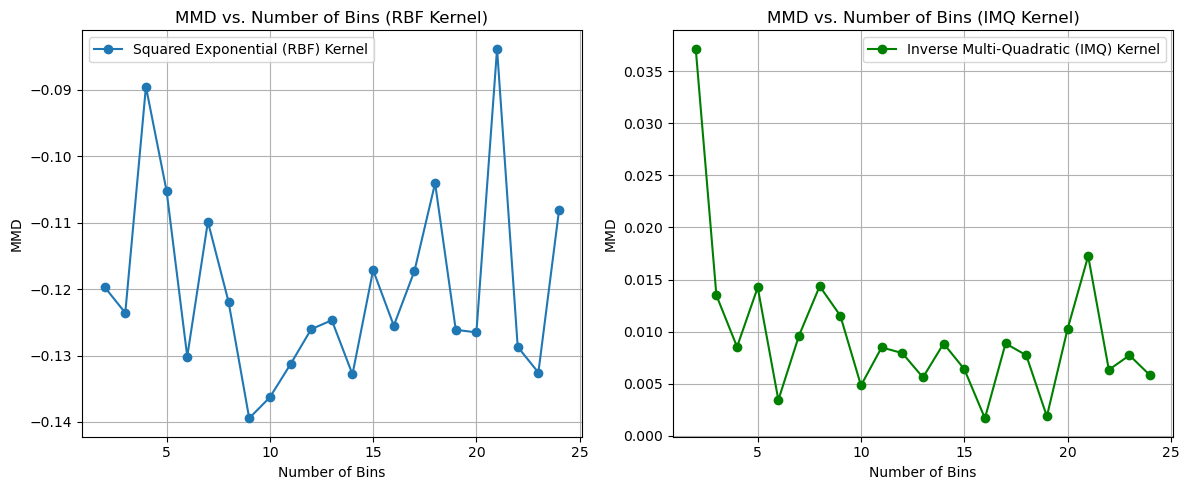

9
16


In [9]:
#1. a two-dimensional histogram
bins=range(2,25)
mmd_rbf=[]
mmd_imq=[]
for b in bins:
    density,new_samples=histogram_density_estimation(X_train, b, 50)
    mmd_rbf.append(calculate_mmd(X_test, new_samples, kernel='rbf', bandwidth=1.0))
    mmd_imq.append(calculate_mmd(X_test, new_samples, kernel='imq', bandwidth=1.0))

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot the MMD values for the Squared Exponential (RBF) Kernel
ax1.plot(bins, mmd_rbf, marker='o', label='Squared Exponential (RBF) Kernel')
ax1.set_xlabel('Number of Bins')
ax1.set_ylabel('MMD')
ax1.set_title('MMD vs. Number of Bins (RBF Kernel)')
ax1.legend()
ax1.grid()
# Plot the MMD values for the Inverse Multi-Quadratic (IMQ) Kernel
ax2.plot(bins, mmd_imq, marker='o',c='green', label='Inverse Multi-Quadratic (IMQ) Kernel')
ax2.set_xlabel('Number of Bins')
ax2.set_ylabel('MMD')
ax2.set_title('MMD vs. Number of Bins (IMQ Kernel)')
ax2.legend()
ax2.grid()
plt.tight_layout() 
plt.show()
print(mmd_rbf.index(min(mmd_rbf))+2)
print(mmd_imq.index(min(mmd_imq))+2)


For the RBF (Radial Basis Function) kernel, the minimum MMD was obtained when using 9 bins.

For the IMQ (Inverse Multi-Quadratic) kernel, the minimum MMD was obtained when using 16 bins.

In [10]:
density,new_samples=histogram_density_estimation(X_train, 16, 50)

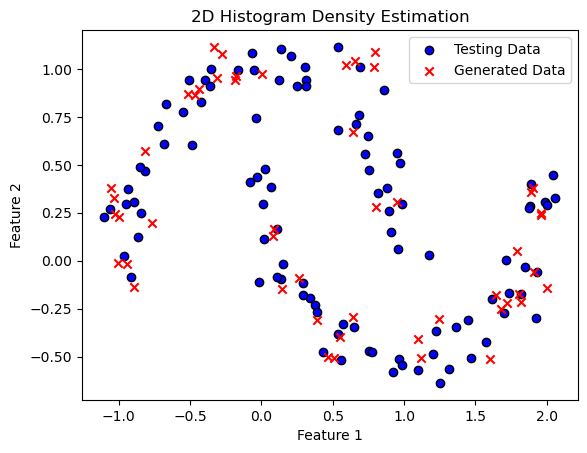

In [11]:
#visualising the training data and the generated data
plt.scatter(X_train[:, 0], X_train[:, 1], c='b', marker='o', edgecolors='k',label='Testing Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], color='red', marker='x', label='Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Histogram Density Estimation')
plt.legend()
plt.show()

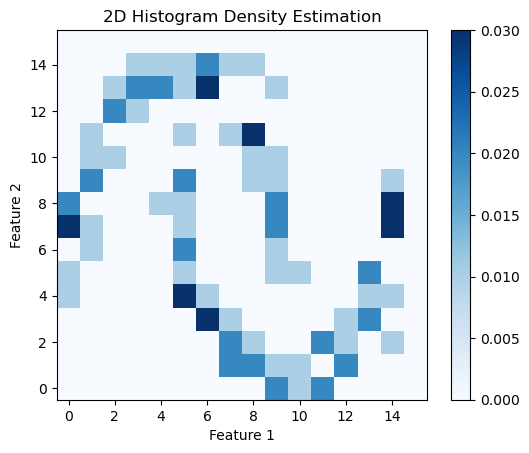

In [12]:
#visualising the learned density
plt.imshow(density.T, origin='lower',cmap='Blues')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Histogram Density Estimation')
plt.show()

In [13]:
density,new_samples=histogram_density_estimation(X_train, 9, 50)

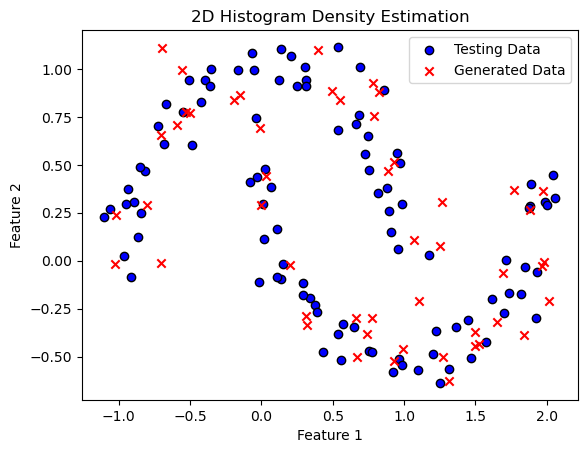

In [14]:
#visualising the training data and the generated data
plt.scatter(X_train[:, 0], X_train[:, 1], c='b', marker='o', edgecolors='k',label='Testing Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], color='red', marker='x', label='Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Histogram Density Estimation')
plt.legend()
plt.show()

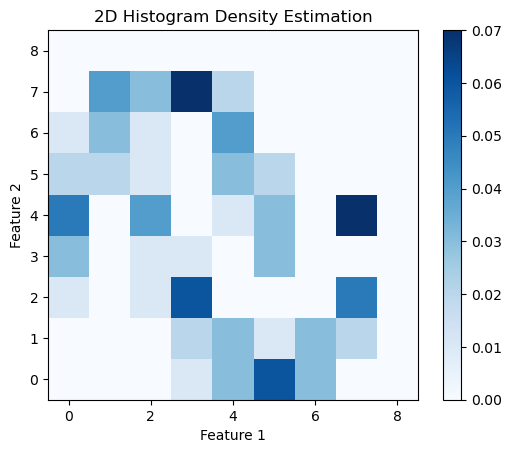

In [15]:
#visualising the learned density
plt.imshow(density.T, origin='lower',cmap='Blues')
plt.colorbar()
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('2D Histogram Density Estimation')
plt.show()

These configurations produced density estimates that closely resembled the true underlying data distribution.

####  Single Gaussian

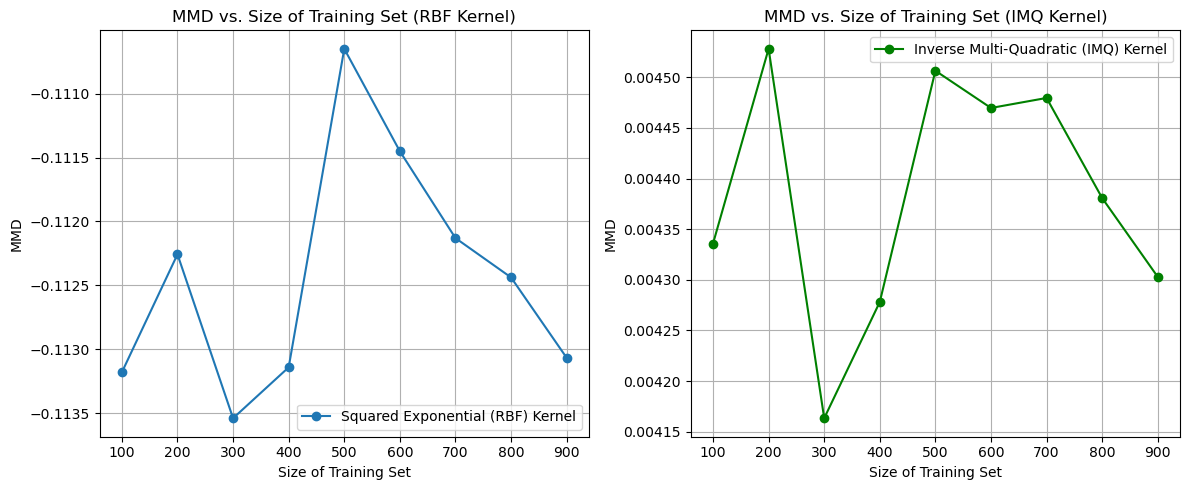

In [16]:
#2. a single Gaussian
training_set_size=range(100,1000,100)
mmd_rbf=[]
mmd_imq=[]
for set_size in training_set_size:
    X, _ = make_moons(n_samples=set_size, noise=0.1, random_state=0)
    density,new_samples=generate_single_gaussian_data(X, 50)
    mmd_rbf.append(calculate_mmd(X_test, new_samples, kernel='rbf', bandwidth=1.0))
    mmd_imq.append(calculate_mmd(X_test, new_samples, kernel='imq', bandwidth=1.0))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot the MMD values for the Squared Exponential (RBF) Kernel
ax1.plot(training_set_size, mmd_rbf, marker='o', label='Squared Exponential (RBF) Kernel')
ax1.set_xlabel('Size of Training Set')
ax1.set_ylabel('MMD')
ax1.set_title('MMD vs. Size of Training Set (RBF Kernel)')
ax1.legend()
ax1.grid()
# Plot the MMD values for the Inverse Multi-Quadratic (IMQ) Kernel
ax2.plot(training_set_size, mmd_imq, marker='o',c='green', label='Inverse Multi-Quadratic (IMQ) Kernel')
ax2.set_xlabel('Size of Training Set')
ax2.set_ylabel('MMD')
ax2.set_title('MMD vs. Size of Training Set (IMQ Kernel)')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()

Training Set of size 300 data points has the minimum MMD for both RBF (Radial Basis Function) kernel and IMQ (Inverse Multi-Quadratic) kernel.

In [17]:
X, _ = make_moons(n_samples=300, noise=0.1, random_state=0)
density,new_samples=generate_single_gaussian_data(X, 50)

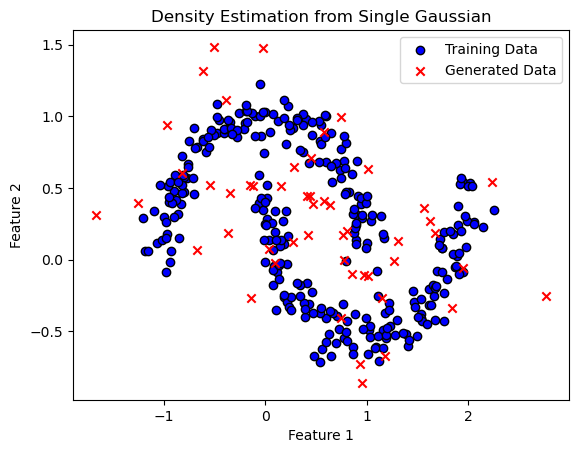

In [18]:
#visualising the training data and the generated data
plt.scatter(X[:, 0], X[:, 1], c='b', marker='o', edgecolors='k',label='Training Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], color='red', marker='x', label='Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Density Estimation from Single Gaussian')
plt.legend()
plt.show()

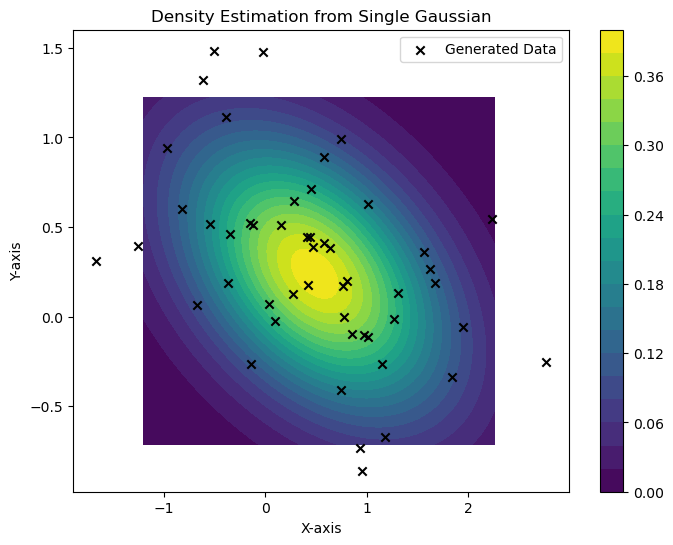

In [19]:
# Visualize the generated density as a contour plot
x, y = np.meshgrid(np.linspace(X[:, 0].min(), X[:, 0].max(), 100),
                   np.linspace(X[:, 1].min(), X[:, 1].max(), 100))
xy = np.column_stack([x.flatten(), y.flatten()])
density_leanred = density.pdf(xy)
density_leanred = density_leanred.reshape(x.shape)

plt.figure(figsize=(8, 6))
plt.contourf(x, y, density_leanred, levels=20, cmap='viridis')
plt.title('Density Estimation from Single Gaussian')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()
plt.scatter(new_samples[:, 0], new_samples[:, 1], color='black', marker='x', label='Generated Data')
plt.legend()
plt.show()

The density estimate using the single Gaussian is not as accurate as the other classical models.

#### Gaussian mixture model (GMM)

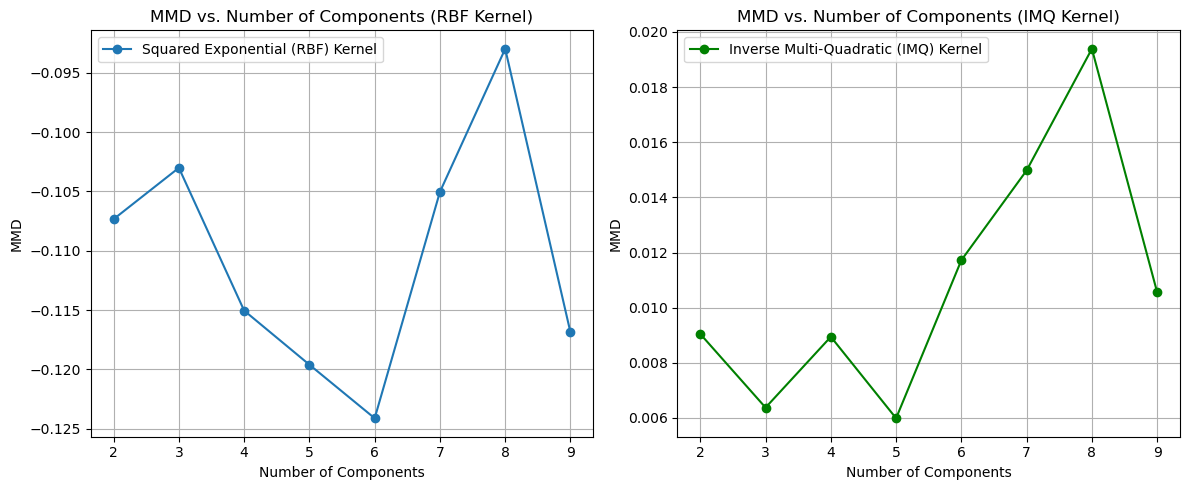

In [20]:
# 3. a Gaussian mixture model (GMM)
components=range(2,10)
mmd_rbf=[]
mmd_imq=[]
for num_components in components:
    density,new_samples=gmm_density_estimation_and_sampling(X_train, num_components, 50)
    mmd_rbf.append(calculate_mmd(X_test, new_samples, kernel='rbf', bandwidth=1.0))
    mmd_imq.append(calculate_mmd(X_test, new_samples, kernel='imq', bandwidth=1.0))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot the MMD values for the Squared Exponential (RBF) Kernel
ax1.plot(components, mmd_rbf, marker='o', label='Squared Exponential (RBF) Kernel')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('MMD')
ax1.set_title('MMD vs. Number of Components (RBF Kernel)')
ax1.legend()
ax1.grid()
# Plot the MMD values for the Inverse Multi-Quadratic (IMQ) Kernel
ax2.plot(components, mmd_imq, marker='o',c='green', label='Inverse Multi-Quadratic (IMQ) Kernel')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('MMD')
ax2.set_title('MMD vs. Number of Components (IMQ Kernel)')
ax2.legend()
ax2.grid()
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

For the RBF (Radial Basis Function) kernel, the minimum MMD was obtained when using 6 components.

For the IMQ (Inverse Multi-Quadratic) kernel, the minimum MMD was obtained when using 5 components.

In [29]:
density_estimate, new_samples = gmm_density_estimation_and_sampling(X_train,6,50)

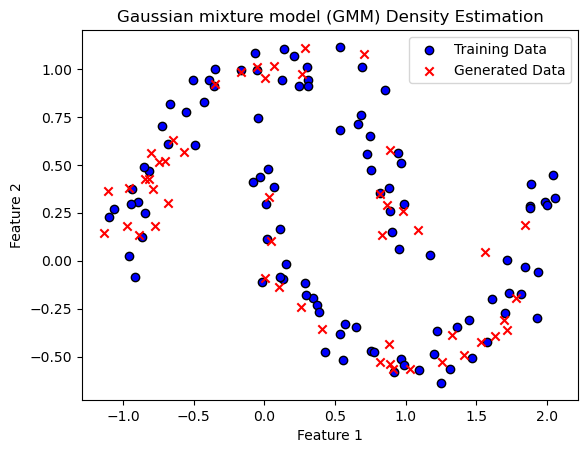

In [30]:
#visualising the training data and the generated data
plt.scatter(X_train[:, 0], X_train[:, 1], c='b', marker='o', edgecolors='k',label='Training Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], color='red', marker='x', label='Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian mixture model (GMM) Density Estimation')
plt.legend()
plt.show()

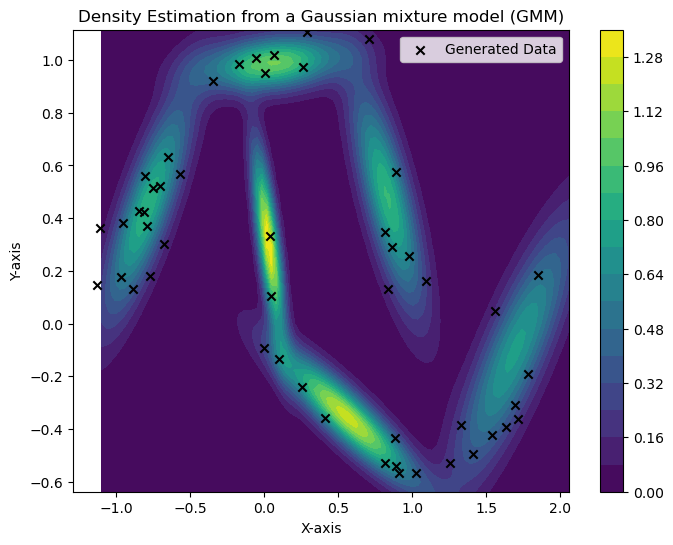

In [31]:
# Visualize the generated density as a contour plot
x, y = np.meshgrid(np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100),
                   np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100))

plt.figure(figsize=(8, 6))
plt.contourf(x, y, density_estimate, levels=20, cmap='viridis')
plt.title('Density Estimation from a Gaussian mixture model (GMM)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()
plt.scatter(new_samples[:, 0], new_samples[:, 1], color='black', marker='x', label='Generated Data')
plt.legend()
plt.show()

In [35]:
density_estimate, new_samples = gmm_density_estimation_and_sampling(X_train,5,50)

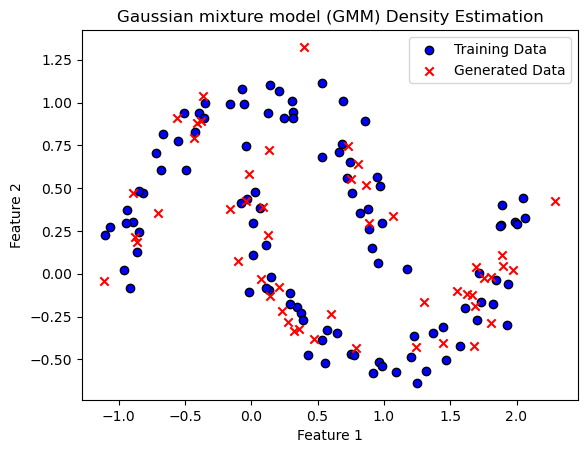

In [36]:
#visualising the training data and the generated data
plt.scatter(X_train[:, 0], X_train[:, 1], c='b', marker='o', edgecolors='k',label='Training Data')
plt.scatter(new_samples[:, 0], new_samples[:, 1], color='red', marker='x', label='Generated Data')
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Gaussian mixture model (GMM) Density Estimation')
plt.legend()
plt.show()

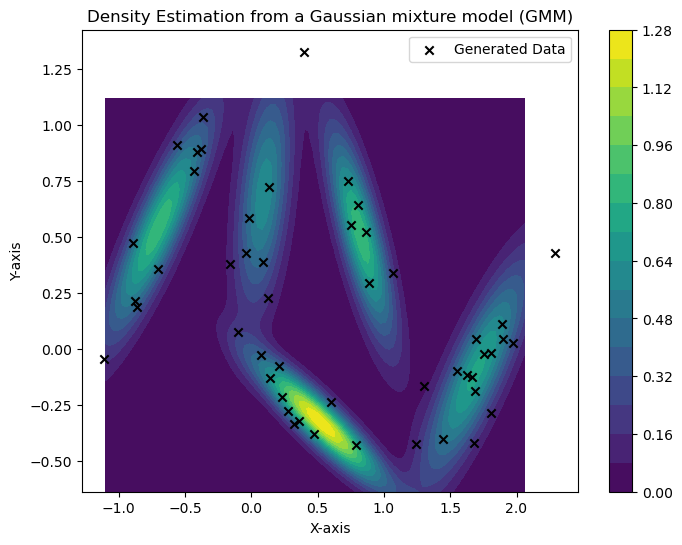

In [37]:
# Visualize the generated density as a contour plot
x, y = np.meshgrid(np.linspace(X_train[:, 0].min(), X_train[:, 0].max(), 100),
                   np.linspace(X_train[:, 1].min(), X_train[:, 1].max(), 100))

plt.figure(figsize=(8, 6))
plt.contourf(x, y, density_estimate, levels=20, cmap='viridis')
plt.title('Density Estimation from a Gaussian mixture model (GMM)')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.colorbar()
plt.scatter(new_samples[:, 0], new_samples[:, 1], color='black', marker='x', label='Generated Data')
plt.legend()
plt.show()

These configurations produced density estimates that closely resembled the true underlying data distribution.

#### kernel density estimator (KDE)

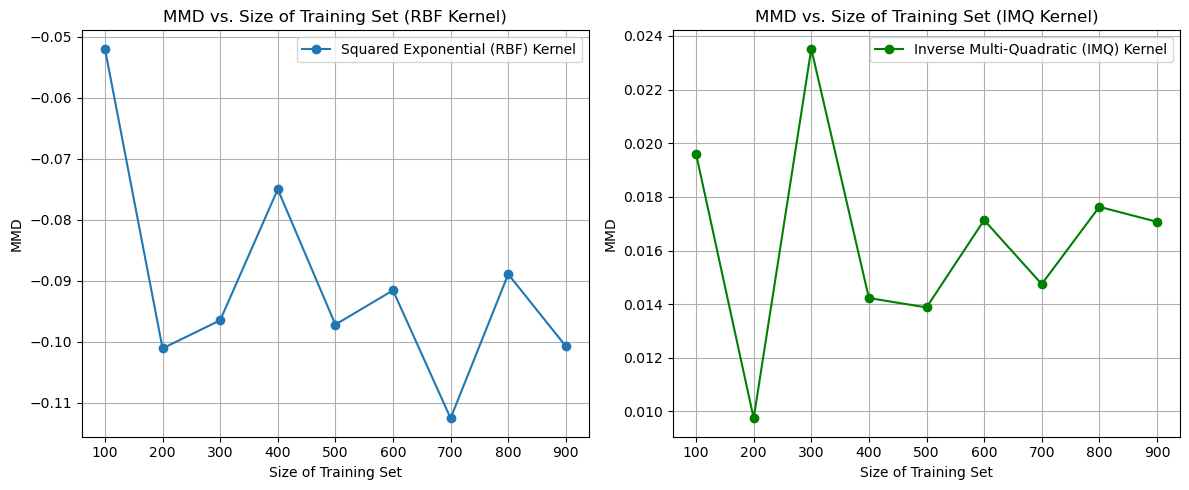

In [57]:
# 4. a kernel density estimator (KDE) with squared exponential kernel
training_set_size=range(100,1000,100)
mmd_rbf=[]
mmd_imq=[]
for set_size in training_set_size:
    X, _ = make_moons(n_samples=set_size, noise=0.1, random_state=0)
    samples_x = sample_from_kde(X[:, 0], 50)
    samples_y = sample_from_kde(X[:, 1], 50)
    new_samples=np.column_stack((samples_x, samples_y))
    mmd_rbf.append(calculate_mmd(X_test, new_samples, kernel='rbf', bandwidth=1.0))
    mmd_imq.append(calculate_mmd(X_test, new_samples, kernel='imq', bandwidth=1.0))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot the MMD values for the Squared Exponential (RBF) Kernel
ax1.plot(training_set_size, mmd_rbf, marker='o', label='Squared Exponential (RBF) Kernel')
ax1.set_xlabel('Size of Training Set')
ax1.set_ylabel('MMD')
ax1.set_title('MMD vs. Size of Training Set (RBF Kernel)')
ax1.legend()
ax1.grid()
# Plot the MMD values for the Inverse Multi-Quadratic (IMQ) Kernel
ax2.plot(training_set_size, mmd_imq, marker='o',c='green', label='Inverse Multi-Quadratic (IMQ) Kernel')
ax2.set_xlabel('Size of Training Set')
ax2.set_ylabel('MMD')
ax2.set_title('MMD vs. Size of Training Set (IMQ Kernel)')
ax2.legend()
ax2.grid()
plt.tight_layout()
plt.show()

For the RBF (Radial Basis Function) kernel, the minimum MMD was obtained when using a training set of size 700.

For the IMQ (Inverse Multi-Quadratic) kernel, the minimum MMD was obtained when using a training set of size 200.

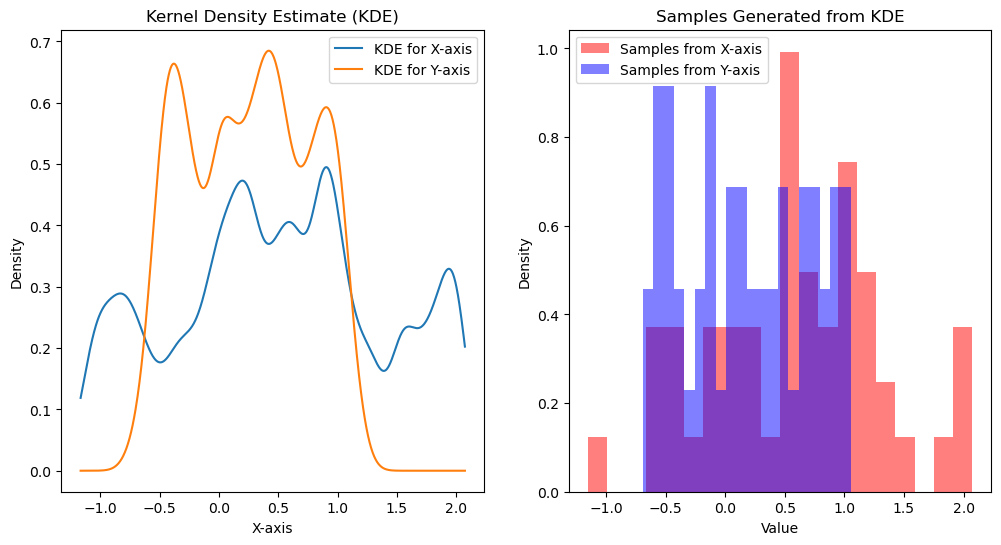

In [58]:
# Visualize the KDE and generated samples
# Define the range for density estimation
X, _ = make_moons(n_samples=200, noise=0.1, random_state=0)
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)

# Calculate the KDE values
kde_values_x = kernel_density_estimate(X[:, 0], x_range, bandwidth=0.1)
kde_values_y = kernel_density_estimate(X[:, 1], x_range, bandwidth=0.1)

# Generate samples from the KDE
num_samples = 50
samples_x = sample_from_kde(X[:, 0], num_samples)
samples_y = sample_from_kde(X[:, 1], num_samples)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(x_range, kde_values_x, label='KDE for X-axis')
plt.plot(x_range, kde_values_y, label='KDE for Y-axis')
plt.title('Kernel Density Estimate (KDE)')
plt.xlabel('X-axis')
plt.ylabel('Density')
plt.legend()
plt.subplot(122)
plt.hist(samples_x, bins=20, density=True, alpha=0.5, color='r', label='Samples from X-axis')
plt.hist(samples_y, bins=20, density=True, alpha=0.5, color='b', label='Samples from Y-axis')
plt.title('Samples Generated from KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

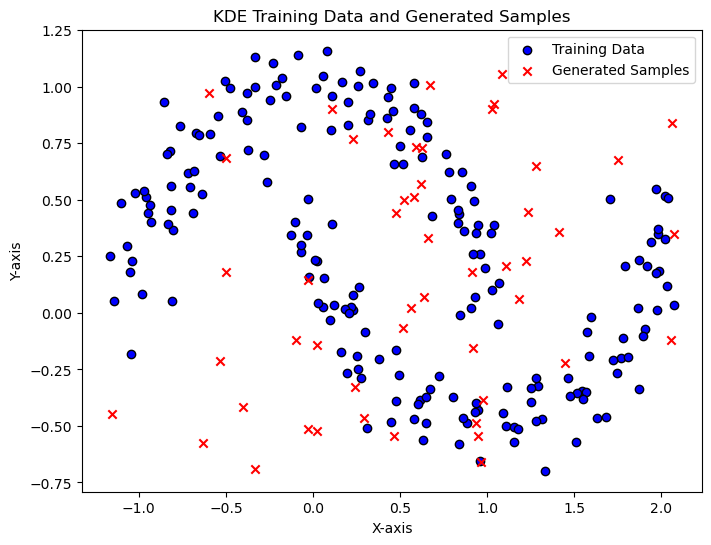

In [59]:
# Visualize the training data and generated samples as a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='b', marker='o', label='Training Data', edgecolors='k')
plt.scatter(samples_x, samples_y, c='r', marker='x', label='Generated Samples')
plt.title('KDE Training Data and Generated Samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

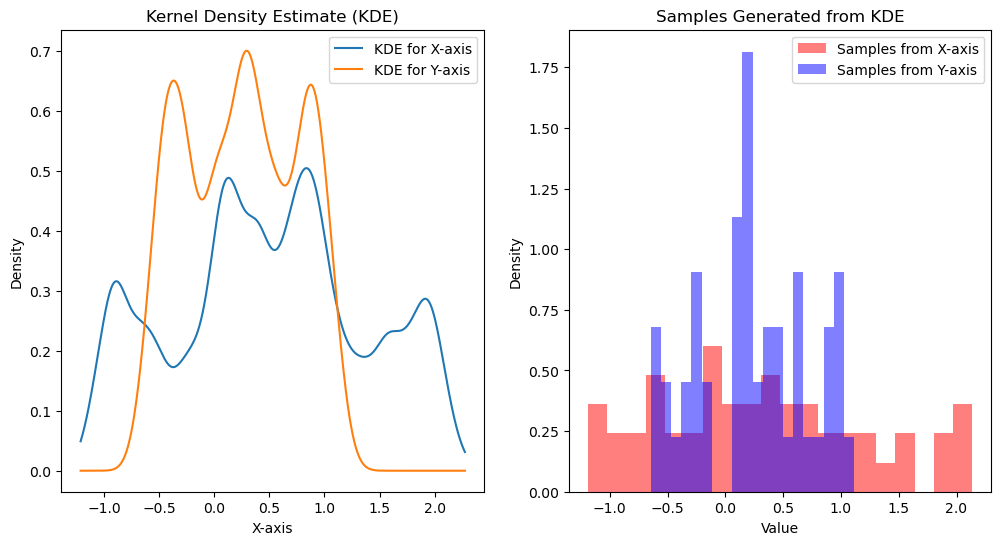

In [60]:
# Visualize the KDE and generated samples
# Define the range for density estimation
X, _ = make_moons(n_samples=700, noise=0.1, random_state=0)
x_range = np.linspace(X[:, 0].min(), X[:, 0].max(), 1000)

# Calculate the KDE values
kde_values_x = kernel_density_estimate(X[:, 0], x_range, bandwidth=0.1)
kde_values_y = kernel_density_estimate(X[:, 1], x_range, bandwidth=0.1)

# Generate samples from the KDE
num_samples = 50
samples_x = sample_from_kde(X[:, 0], num_samples)
samples_y = sample_from_kde(X[:, 1], num_samples)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.plot(x_range, kde_values_x, label='KDE for X-axis')
plt.plot(x_range, kde_values_y, label='KDE for Y-axis')
plt.title('Kernel Density Estimate (KDE)')
plt.xlabel('X-axis')
plt.ylabel('Density')
plt.legend()
plt.subplot(122)
plt.hist(samples_x, bins=20, density=True, alpha=0.5, color='r', label='Samples from X-axis')
plt.hist(samples_y, bins=20, density=True, alpha=0.5, color='b', label='Samples from Y-axis')
plt.title('Samples Generated from KDE')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()
plt.show()

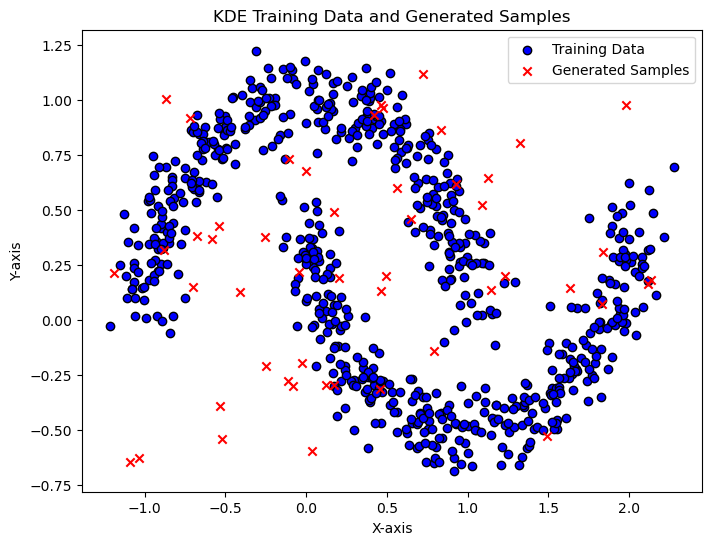

In [61]:
# Visualize the training data and generated samples as a scatter plot
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c='b', marker='o', label='Training Data', edgecolors='k')
plt.scatter(samples_x, samples_y, c='r', marker='x', label='Generated Samples')
plt.title('KDE Training Data and Generated Samples')
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.legend()
plt.show()

The density estimate using the kernel density estimator (KDE) with squared exponential kernel is not as accurate as the other classical models.Here Kernel bandwith is calculated using the Silverman's rule of thumb-->h = 1.06 * min(std_dev, IQR / 1.34) * n^(-1/5)

## 2 Higher-dimensional data

In [89]:
from sklearn.datasets import load_digits
from sklearn.model_selection import train_test_split
from sklearn.mixture import GaussianMixture
from sklearn.neighbors import KernelDensity
import matplotlib.pyplot as plt
digits = load_digits()
X = digits.data
y = digits.target
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

In [90]:
print(X_train.shape,X_test.shape)

(1437, 64) (360, 64)


#### Gaussian mixture model (GMM)

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(
D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than avai

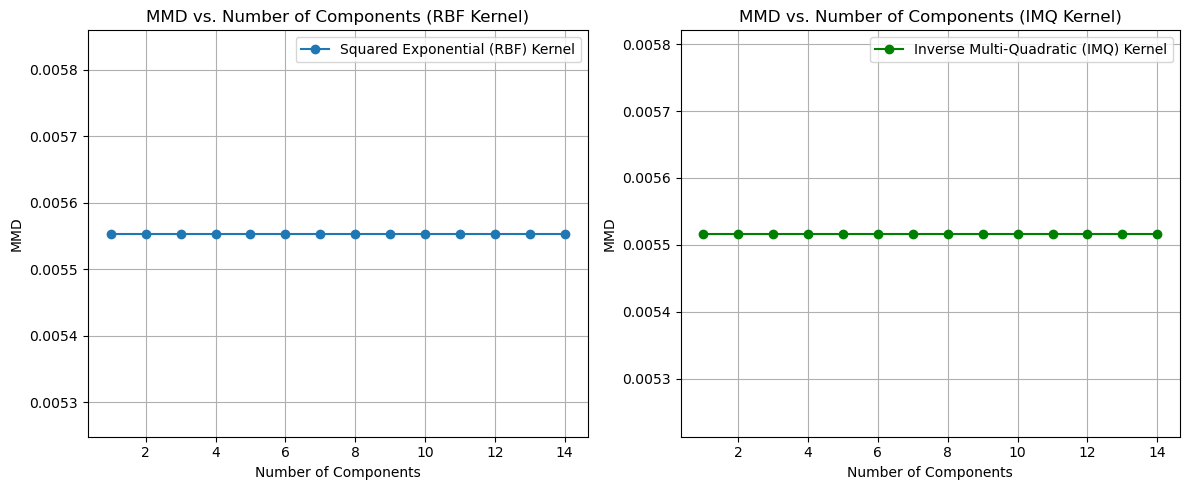

In [91]:
# 3. a Gaussian mixture model (GMM)
components=range(1,15)
mmd_rbf=[]
mmd_imq=[]
for num_components in components:
    gmm = GaussianMixture(n_components=n_components, random_state=0)
    gmm.fit(X_train)
    num_samples = X_test.shape[0] 
    new_samples = gmm.sample(num_samples)
    mmd_rbf.append(calculate_mmd(X_test, new_samples[0], kernel='rbf', bandwidth=1.0))
    mmd_imq.append(calculate_mmd(X_test, new_samples[0], kernel='imq', bandwidth=1.0))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot the MMD values for the Squared Exponential (RBF) Kernel
ax1.plot(components, mmd_rbf, marker='o', label='Squared Exponential (RBF) Kernel')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('MMD')
ax1.set_title('MMD vs. Number of Components (RBF Kernel)')
ax1.legend()
ax1.grid()
# Plot the MMD values for the Inverse Multi-Quadratic (IMQ) Kernel
ax2.plot(components, mmd_imq, marker='o',c='green', label='Inverse Multi-Quadratic (IMQ) Kernel')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('MMD')
ax2.set_title('MMD vs. Number of Components (IMQ Kernel)')
ax2.legend()
ax2.grid()
plt.tight_layout()  # Ensures proper spacing between subplots
plt.show()

#### Single Gaussian

In [108]:
# Single Gaussian
n_components=1
gmm_1 = GaussianMixture(n_components=n_components, random_state=0)
gmm_1.fit(X_train)
num_samples = 360
new_samples = gmm_1.sample(num_samples)
print("Number of Components",n_components)
print("MMD for RBF kernel",calculate_mmd(X_test, new_samples[0], kernel='rbf', bandwidth=1.0))
print("MMD for IMQ kernel",calculate_mmd(X_test, new_samples[0], kernel='imq', bandwidth=1.0))

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Number of Components 1
MMD for RBF kernel 0.005555530909265318
MMD for IMQ kernel 0.005687173226737629


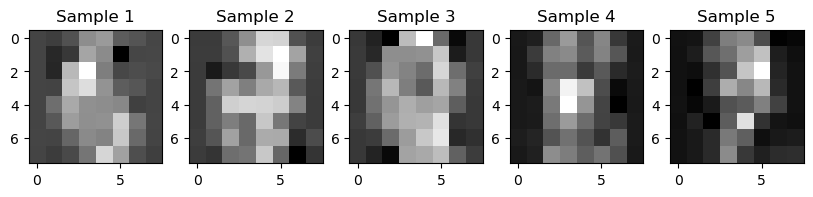

In [109]:
# Visualize the generated samples
plt.figure(figsize=(10, 2))
num_samples=5
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(new_samples[0][i].reshape(8, 8), cmap=plt.cm.gray)
    plt.title(f'Sample {i + 1}')

plt.show()

#### Gaussian mixture model (GMM)

In [110]:
# Guassian Mixture Model
n_components=10
gmm_10 = GaussianMixture(n_components=n_components, random_state=0)
gmm_10.fit(X_train)
num_samples = 360
new_samples = gmm_10.sample(num_samples)
print("Number of Components",n_components)
print("MMD for RBF kernel",calculate_mmd(X_test, new_samples[0], kernel='rbf', bandwidth=1.0))
print("MMD for IMQ kernel",calculate_mmd(X_test, new_samples[0], kernel='imq', bandwidth=1.0))

D:\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=6.
  warnings.warn(


Number of Components 10
MMD for RBF kernel 0.005555179794637385
MMD for IMQ kernel 0.005578638542454568


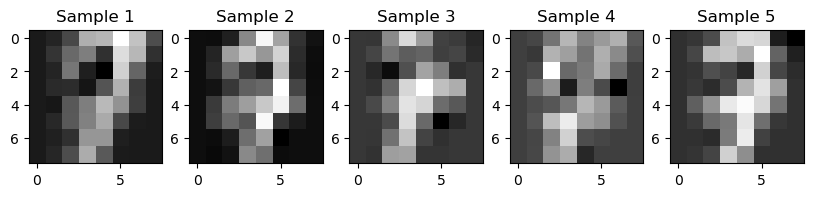

In [111]:
# Visualize the generated samples
plt.figure(figsize=(10, 2))
num_samples=5
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(new_samples[0][i].reshape(8, 8), cmap=plt.cm.gray)
    plt.title(f'Sample {i + 1}')

plt.show()

The data distribution of handwritten digits in the load_digits dataset is not well approximated by a GMM.But the GMM with 10 components does slightly better than the single Guassian.

#### Kernel Density Estimator (KDE)

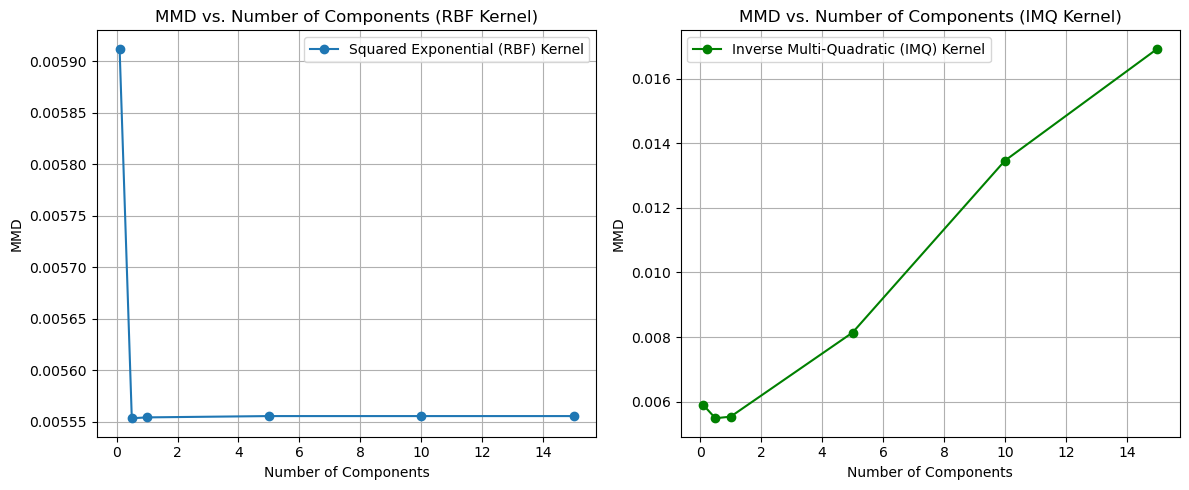

In [96]:
# 4. a kernel density estimator (KDE) with squared exponential kernel
bandwidths = [0.1, 0.5, 1.0, 5.0, 10.0, 15.0]
mmd_rbf=[]
mmd_imq=[]
for bandwidth in bandwidths:
    kde = KernelDensity(bandwidth=bandwidth)
    kde.fit(X_train)
    num_samples = X_test.shape[0]  
    new_samples = kde.sample(num_samples)
    mmd_rbf.append(calculate_mmd(X_test, new_samples, kernel='rbf', bandwidth=1.0))
    mmd_imq.append(calculate_mmd(X_test, new_samples, kernel='imq', bandwidth=1.0))
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
# Plot the MMD values for the Squared Exponential (RBF) Kernel
ax1.plot(bandwidths, mmd_rbf, marker='o', label='Squared Exponential (RBF) Kernel')
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('MMD')
ax1.set_title('MMD vs. Number of Components (RBF Kernel)')
ax1.legend()
ax1.grid()
# Plot the MMD values for the Inverse Multi-Quadratic (IMQ) Kernel
ax2.plot(bandwidths, mmd_imq, marker='o',c='green', label='Inverse Multi-Quadratic (IMQ) Kernel')
ax2.set_xlabel('Number of Components')
ax2.set_ylabel('MMD')
ax2.set_title('MMD vs. Number of Components (IMQ Kernel)')
ax2.legend()
ax2.grid()
plt.tight_layout()  
plt.show()

In [97]:
kde = KernelDensity(bandwidth=0.5)
kde.fit(X_train)
num_samples = X_test.shape[0]  
new_samples = kde.sample(num_samples)
print("Bandwidth=0.5")
print("MMD for RBF kernel",calculate_mmd(X_test, new_samples, kernel='rbf', bandwidth=1.0))
print("MMD for IMQ kernel",calculate_mmd(X_test, new_samples, kernel='imq', bandwidth=1.0))

Bandwidth=0.5
MMD for RBF kernel 0.00555362654954266
MMD for IMQ kernel 0.005543796254751685


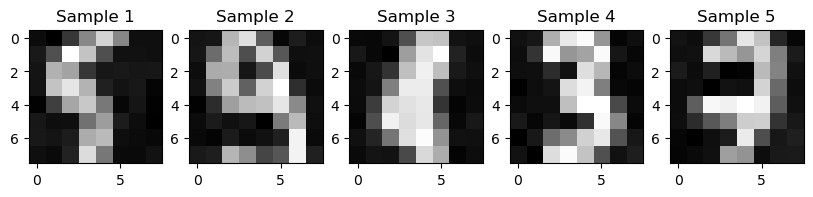

In [98]:
# Visualize the generated samples
plt.figure(figsize=(10, 2))
num_samples=5
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    plt.title(f'Sample {i + 1}')

plt.show()

In [99]:
kde = KernelDensity(bandwidth=1.0)
kde.fit(X_train)
num_samples = X_test.shape[0]  
new_samples = kde.sample(num_samples)
print("Bandwidth=1.0")
print("MMD for RBF kernel",calculate_mmd(X_test, new_samples, kernel='rbf', bandwidth=1.0))
print("MMD for IMQ kernel",calculate_mmd(X_test, new_samples, kernel='imq', bandwidth=1.0))

Bandwidth=1.0
MMD for RBF kernel 0.00555421409187281
MMD for IMQ kernel 0.0055126696027805525


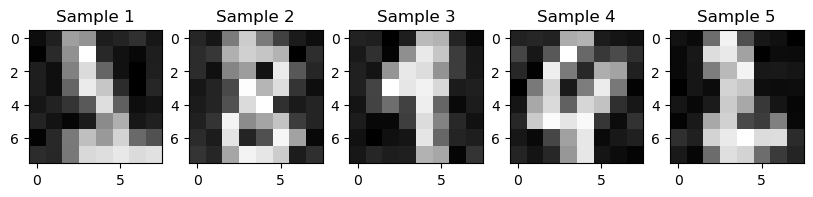

In [100]:
# Visualize the generated samples
plt.figure(figsize=(10, 2))
num_samples=5
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(new_samples[i].reshape(8, 8), cmap=plt.cm.gray)
    plt.title(f'Sample {i + 1}')

plt.show()

The Kernel Density Estimation (KDE) model performs better than GMM in approximating the data distribution of handwritten digits.

In [137]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
# Train a RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state=42)
clf.fit(X_train, y_train)

RandomForestClassifier(random_state=42)

In [138]:
num_samples=360
new_samples_GMM_1=gmm_1.sample(num_samples)
new_samples_GMM_10=gmm_10.sample(num_samples)
new_samples_KDE=kde.sample(num_samples)

In [139]:
generated_predictions = clf.predict(new_samples_GMM_1[0])
print(generated_predictions)

[6 7 4 8 7 2 7 9 3 2 8 6 4 8 2 8 4 8 8 8 8 8 4 8 2 7 9 8 3 4 8 3 3 7 4 3 5
 9 9 0 8 4 8 8 3 5 7 9 9 2 7 8 9 9 2 8 8 5 2 4 0 8 3 4 4 8 8 8 8 6 0 6 6 8
 3 8 4 5 9 1 0 4 8 8 1 9 8 9 8 3 8 9 9 8 8 4 6 7 8 0 1 0 7 5 4 2 9 9 9 4 8
 8 9 0 8 4 9 6 2 5 8 2 3 9 7 4 8 9 8 8 8 0 8 0 7 7 5 2 2 6 2 8 8 2 5 9 5 5
 4 7 8 9 7 2 7 6 8 6 3 9 0 3 4 8 4 8 6 7 4 8 7 6 7 0 7 8 8 1 8 8 9 9 4 5 0
 0 8 2 5 9 9 3 9 7 9 8 8 9 6 9 2 5 8 3 0 0 9 5 5 9 9 5 8 3 8 9 3 6 8 2 9 8
 8 7 0 7 0 2 7 2 5 8 5 2 3 9 5 8 4 8 6 3 9 3 9 8 7 2 6 8 3 8 4 6 8 8 8 0 8
 9 8 0 0 6 7 9 1 4 8 5 4 7 7 8 0 4 2 4 7 8 9 3 0 3 9 4 9 6 5 2 9 8 2 8 7 6
 0 4 8 8 8 8 4 3 4 9 8 8 8 2 9 8 6 0 9 3 8 8 6 4 8 4 2 8 8 7 3 2 2 4 0 3 1
 4 9 8 8 8 2 2 4 3 8 2 8 8 9 2 0 7 3 9 9 6 2 9 3 3 5 8]


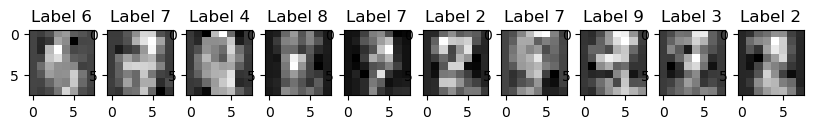

In [140]:
# Visualize the generated samples
plt.figure(figsize=(10, 2))
num_samples=10
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(new_samples_GMM_1[0][i].reshape(8, 8), cmap=plt.cm.gray)
    plt.title(f'Label {generated_predictions[i]}')

plt.show()

In [141]:
generated_predictions = clf.predict(new_samples_GMM_10[0])
print(generated_predictions)

[7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 7 4 7 7 7 7 7 4 7 7 7 4 7 7 7 7 7 7 7 7 7
 7 7 7 7 7 4 7 7 7 7 4 7 7 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3 3
 3 3 9 3 3 3 3 3 3 3 6 6 6 6 6 6 6 6 6 6 6 6 6 6 4 0 6 4 4 6 6 6 4 6 6 6 6
 6 4 6 6 6 6 6 6 6 8 8 8 8 8 8 2 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 2 8 8 8
 8 3 8 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 9 9
 9 5 3 9 9 9 9 9 9 9 9 9 9 9 5 9 5 5 9 9 9 9 5 3 9 8 9 9 9 9 9 9 9 8 5 4 1
 4 4 4 4 8 4 1 4 7 9 4 4 1 1 4 4 9 4 1 4 4 4 4 4 9 9 9 4 8 4 4 4 4 1 1 1 1
 4 1 4 4 9 4 8 4 4 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 5 1 1 1
 1 1 1 1 1 1 1 1 4 4 4 4 1 8 1 4 1 1 1 1 1 1 1 1 1 1 1]


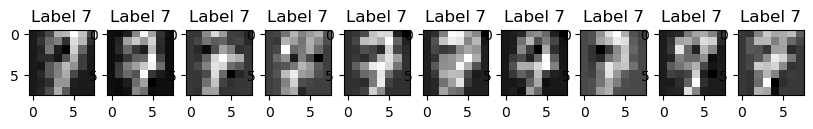

In [142]:
# Visualize the generated samples
plt.figure(figsize=(10, 2))
num_samples=10
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(new_samples_GMM_10[0][i].reshape(8, 8), cmap=plt.cm.gray)
    plt.title(f'Label {generated_predictions[i]}')

plt.show()

In [143]:
generated_predictions = clf.predict(new_samples_KDE)
print(generated_predictions)

[2 7 1 7 8 8 8 7 1 1 2 4 6 3 2 6 3 3 0 2 5 9 5 2 5 3 1 7 5 9 6 1 0 7 7 1 0
 2 2 9 7 8 2 3 9 2 1 5 4 7 0 5 3 7 8 5 1 4 0 1 9 4 4 9 9 8 9 2 1 4 3 1 8 5
 2 8 7 7 2 7 4 0 9 4 8 4 0 6 9 7 1 0 8 5 8 8 0 7 3 4 4 5 0 2 9 9 9 8 0 0 5
 8 9 6 4 1 4 1 3 9 7 4 0 4 5 1 6 3 4 0 1 7 8 7 6 3 8 3 2 3 2 8 1 7 2 6 5 5
 8 1 2 6 0 4 2 0 3 3 9 3 0 8 0 3 2 1 3 0 9 3 5 5 5 6 0 6 2 3 6 2 8 5 3 5 8
 9 8 0 4 0 2 3 6 7 1 4 1 7 0 9 8 8 7 3 1 5 6 1 2 0 2 7 9 3 5 7 8 6 2 2 5 7
 1 8 2 9 0 9 6 9 7 7 0 5 5 2 1 9 8 8 4 2 9 9 5 4 4 6 8 0 5 5 2 7 9 3 2 8 3
 8 0 9 5 5 6 0 9 2 4 7 3 5 8 9 7 3 9 1 0 5 8 3 4 2 4 4 3 6 8 9 9 7 8 0 4 3
 3 7 9 6 1 9 9 8 1 6 7 6 8 3 2 5 1 5 8 1 2 5 9 4 7 1 6 1 8 0 7 4 2 3 0 4 5
 7 9 0 8 0 7 4 3 2 9 5 2 3 0 0 0 8 1 4 2 5 8 5 1 4 0 3]


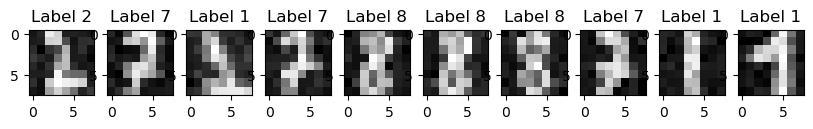

In [144]:
# Visualize the generated samples
plt.figure(figsize=(10, 2))
num_samples=10
for i in range(num_samples):
    plt.subplot(1, num_samples, i + 1)
    plt.imshow(new_samples_KDE[i].reshape(8, 8), cmap=plt.cm.gray)
    plt.title(f'Label {generated_predictions[i]}')

plt.show()

#### DenistyForest

In [146]:
from DensityForest import DensityForest

In [147]:
#Create a DensityForest instance
n_estimators = 10  # Number of estimators (trees)
max_depth = 10  # Max depth for each tree
num_splits = 10  # Number of splits
density_forest = DensityForest(
    n_estimators=n_estimators,
    max_depth=max_depth,
    num_splits=num_splits
)
density_forest.fit(X)

ValueError: all the input array dimensions for the concatenation axis must match exactly, but along dimension 1, the array at index 0 has size 2 and the array at index 1 has size 64

We were not able to rectify these errors for density forest.